In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.linalg import solve_continuous_lyapunov
np.set_printoptions(precision=5, suppress=True)
import time
from utils import * 
from inference import *

In [2]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    J = np.array([[-params[0], params[2]], [-params[3], -params[1]]])
    c = params[3]/params[0]
    B = np.diagflat(params[-2:])**2 
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

In [3]:
class nonlinear_model(sim): 
    
    def __init__(self, params, convert_params):
        super().__init__(params, convert_params) 
        self.b = params[4]

    def _update(self, y, dt):
        det = self.J @ y 
        det[1] -= self.b* y[1]**3 
        sto = np.sqrt(dt) * self.rv.rvs()
        y += det*dt + sto 

In [4]:
class nonlinear_inference(inference):
                   
    def _minuslogP(self, params, trajs, dt):
        '''
        traj: 2 x T 
        '''
        J, B = self.convert_params(params)
        b = params[4]
        invB = np.linalg.inv(B*dt) 
        _, norm = np.linalg.slogdet(invB)

        minuslogp = 0 
        for traj in trajs: 
            N = traj.shape[-1] - 1
            dx = traj[:, 1:] - traj[:, :-1]
            det = J @ traj[:, :-1]
            det[1] -= b*traj[1, :-1]**3 
            diff = dx - det*dt 
    
            minuslogp += np.einsum('ji,jk,ki', diff, invB, diff)/2 
            minuslogp -= N*norm/2
        return minuslogp

### First, we make some simulations with known parameters and infer them with both inference methods

In [5]:
# params in order of [epsilon, gamma-mu*c, mu, c]
dt = 5e-3
n_frames = 5000
T = 3e-2*n_frames
n_repeats = 8

#  epsilon, gamma, mu, c, b, sigma_d, sigma_p  
params = [0.01, 1, 0.2, 1, 20, 0.005, 0.787]

J, B = convert_params(params)
print(J)
print(B)
print(np.linalg.eigvals(J))

m = nonlinear_model(params, convert_params)
results = m.evolve(T, dt, int(n_frames), n_repeats)

[[-0.01  0.2 ]
 [-1.   -1.  ]]
[[0.00003 0.0025 ]
 [0.0025  0.86937]]
[-0.29281 -0.71719]


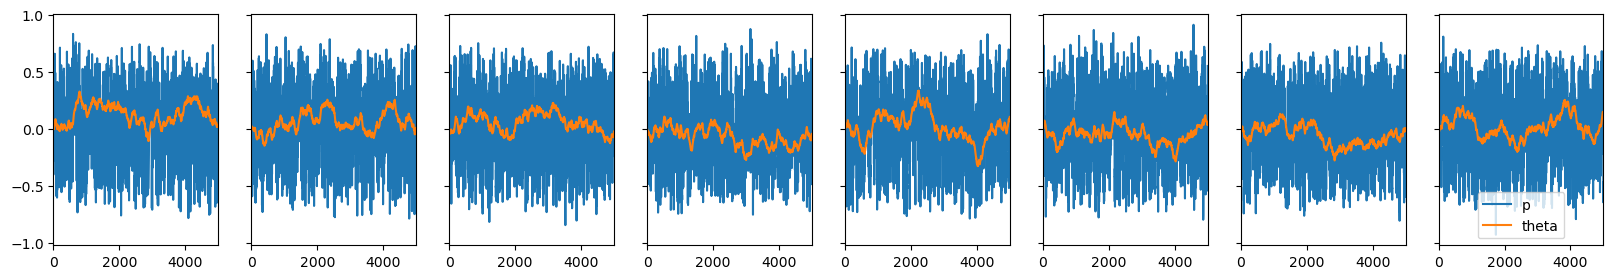

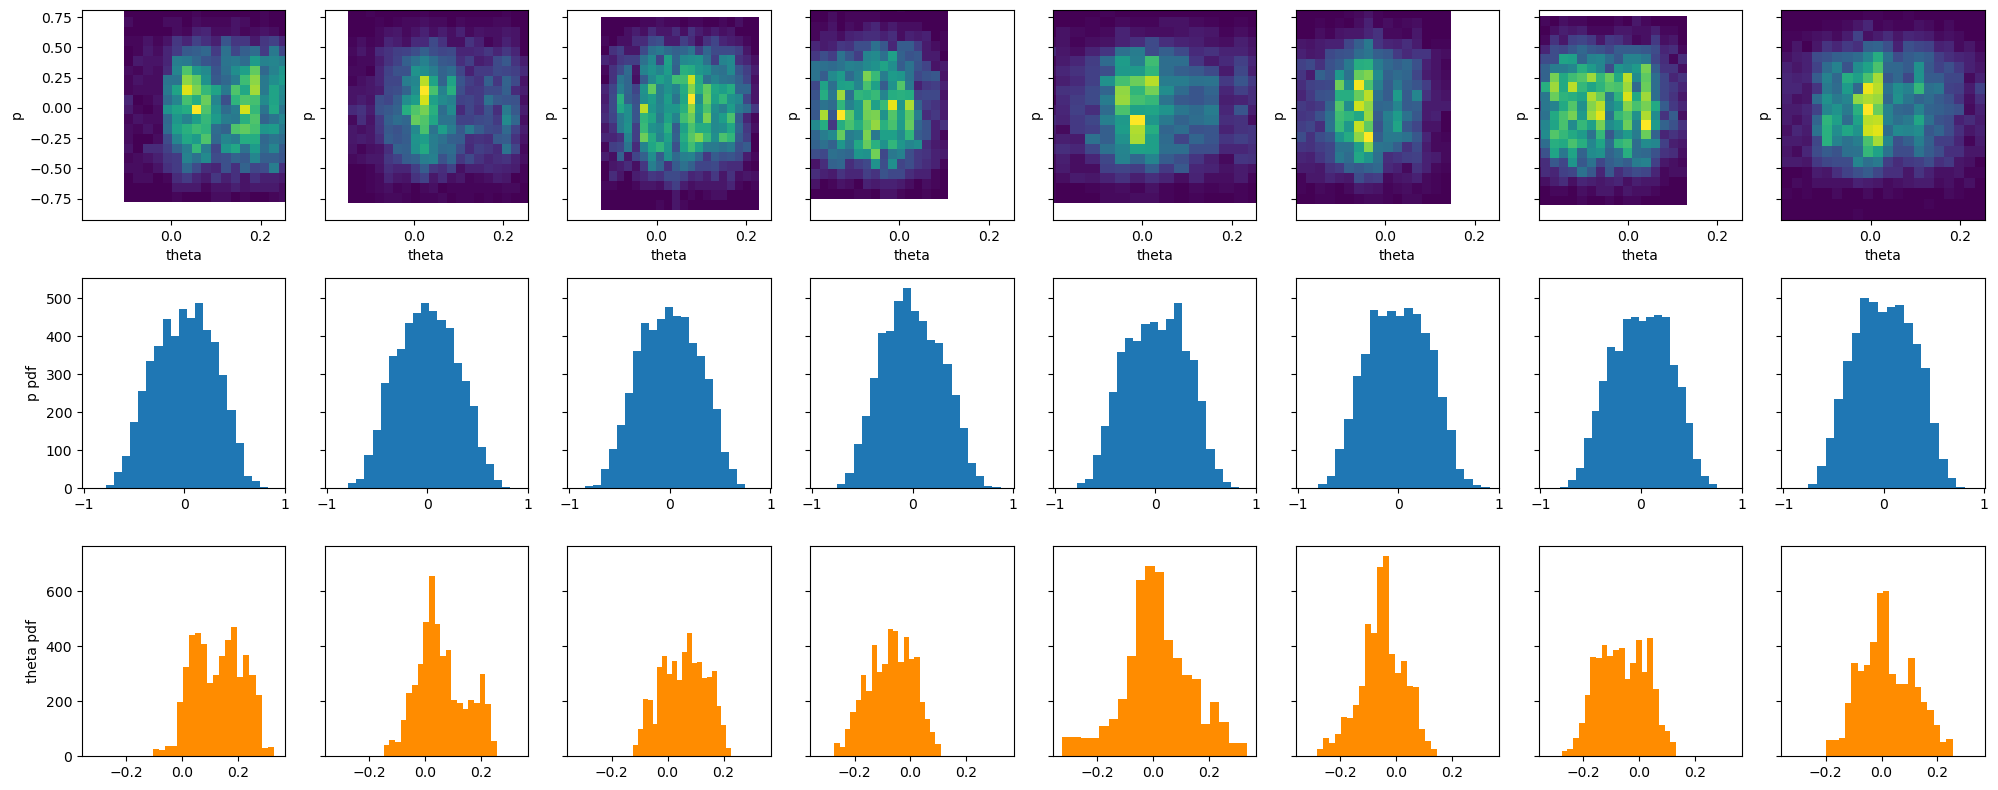

In [6]:
show(results)
plot_dist(results)

In [7]:
inf = nonlinear_inference(convert_params)

t1 = time.time() 
minuslogp = inf._minuslogP(params, results, T/n_frames)
t2 = time.time() 
print('time taken: ', t2-t1)
print(minuslogp)

time taken:  0.0011501312255859375
-314150.6021883295


In [8]:
## Numerical inference
inf = nonlinear_inference(convert_params)
guess = [1, 1, 1, 1, 100, 0.1, 0.1]
bounds = [[1e-6, None]]*7
bounds[1] = [None, None]
MAP, cost = inf.inf(guess, results, (T/n_frames), bounds=bounds)
print(MAP, cost)
print('true params:', params, inf._minuslogP(params, results, T/n_frames))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[ 0.      -1.22377  0.19784  0.0001  20.4343   0.00668  0.60064] -320961.10492432193
true params: [0.01, 1, 0.2, 1, 20, 0.005, 0.787] -314150.6021883295


In [9]:
delta = 1e-4*MAP 
delta[0] = 1e-3
ste, _ = inf.std_error(MAP, results, T/n_frames, delta=delta)
print(ste)

[0.      0.12863 0.00066 0.      0.47418 0.00002 0.00217]


In [10]:
path = 'Data/N11_ThetaPola_DATA/'
files = [f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(path+f)['POLA'])
    else: 
        theta_trajs.append(loadmat(path+f)['THETAd'])

N11_1_R200_B30_04_05_POLARIZATION.mat N11_1_R200_B30_04_05_ThetaTime.mat
N11_1_R200_B50_04_05_POLARIZATION.mat N11_1_R200_B50_04_05_ThetaTime.mat
N11_1_R200_B50_25_04_POLARIZATION.mat N11_1_R200_B50_25_04_ThetaTime.mat
N11_1_R200_B50_26_04_POLARIZATION.mat N11_1_R200_B50_26_04_ThetaTime.mat
N11_2_R200_B50_26_04_POLARIZATION.mat N11_2_R200_B50_26_04_ThetaTime.mat
N11_3_R200_B50_25_04_POLARIZATION.mat N11_3_R200_B50_25_04_ThetaTime.mat
N11_4_R200_B100_25_04_POLARIZATION.mat N11_4_R200_B100_25_04_ThetaTime.mat
N11_4_R200_B30_25_04_POLARIZATION.mat N11_4_R200_B30_25_04_ThetaTime.mat
N11_4_R200_B50_25_04_POLARIZATION.mat N11_4_R200_B50_25_04_ThetaTime.mat
N11_5_R200_B30_25_04_POLARIZATION.mat N11_5_R200_B30_25_04_ThetaTime.mat
N11_5_R200_B50_25_04_POLARIZATION.mat N11_5_R200_B50_25_04_ThetaTime.mat


In [11]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))
theta_trajs.pop(2);
pol_trajs.pop(2); 
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]


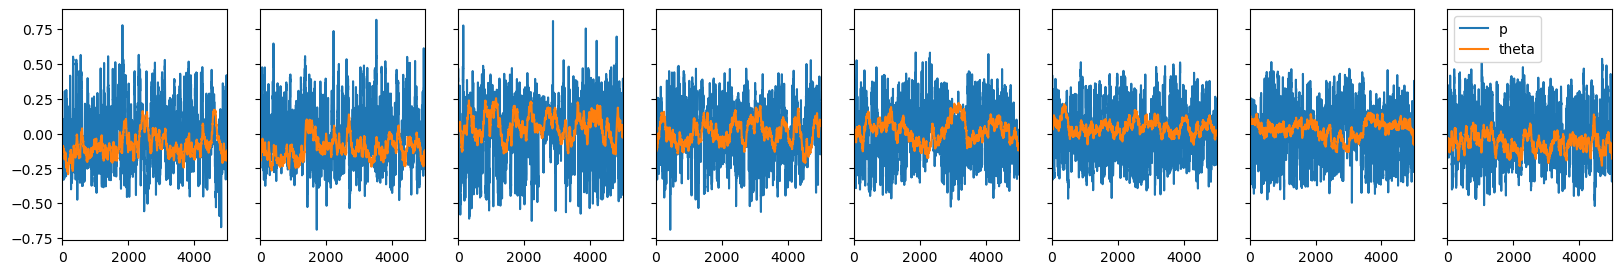

In [13]:
N = 1

f1 = lambda x: (x[:, 1])/180*np.pi # - np.mean(x[:, 1])/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: x[:, 2] - np.mean(x[:, 2])
data = [np.stack([coarsen(f1(theta), N), coarsen(f2(p), N)]) for (theta, p) in zip(theta_trajs, pol_trajs)]
dt = N*0.03333333333333333
show([d for d in data if len(d[0]) == 5000/N])

In [14]:
linear_map = [0.089, 2.537, 0.176, 1, 0, 0.025, 0.787]
guess = [0.1, 0.1, 0.1, 5, 100, 0.02, 1]
bounds = [[0, None]]*7
bounds[1] = [None, None]
inf = nonlinear_inference(convert_params)
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
print(MAP, y)
print(linear_map, inf._minuslogP(linear_map, data, dt))

[0.02172 1.20237 0.32718 0.05522 6.34498 0.02499 0.37406] -313300.7576502486
[0.089, 2.537, 0.176, 1, 0, 0.025, 0.787] -294623.7499748574


In [15]:
delta = MAP*1e-4
delta[0]= 1e-3
std_err, hess = inf.std_error(MAP, data, dt, delta)
print('fractional error:', std_err/MAP)
print('absolute error:', std_err)
print(np.linalg.eigvals(hess)) # check that all eigenvalues of the Hessian are positive 

fractional error: [0.55714 0.06608 0.00988 0.55626 0.09883 0.00336 0.00336]
absolute error: [0.0121  0.07946 0.00323 0.03072 0.62705 0.00008 0.00126]
[1.41817e+08 3.15180e+06 6.32371e+05 9.88230e+04 9.17721e+02 4.20372e+02
 2.51812e+00]


In [16]:
guess = MAP

n_frames = 5000
dt = 0.03333333333333333 
m = nonlinear_model(guess, convert_params)
print(m.J, m.b)
n_repeats = 8
sims = m.evolve(n_frames*dt, 3.3e-3, n_frames, n_repeats)

[[-0.02172  0.32718]
 [-0.05522 -1.20237]] 6.344981913707887


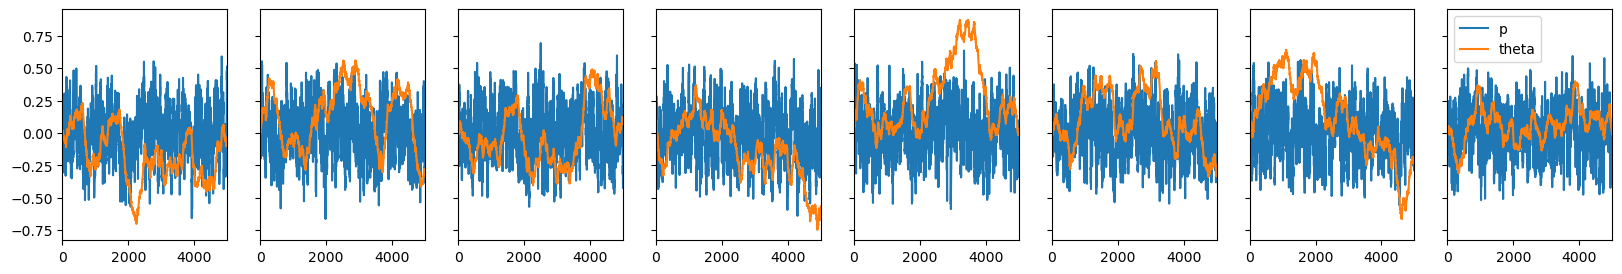

In [17]:
show(sims)

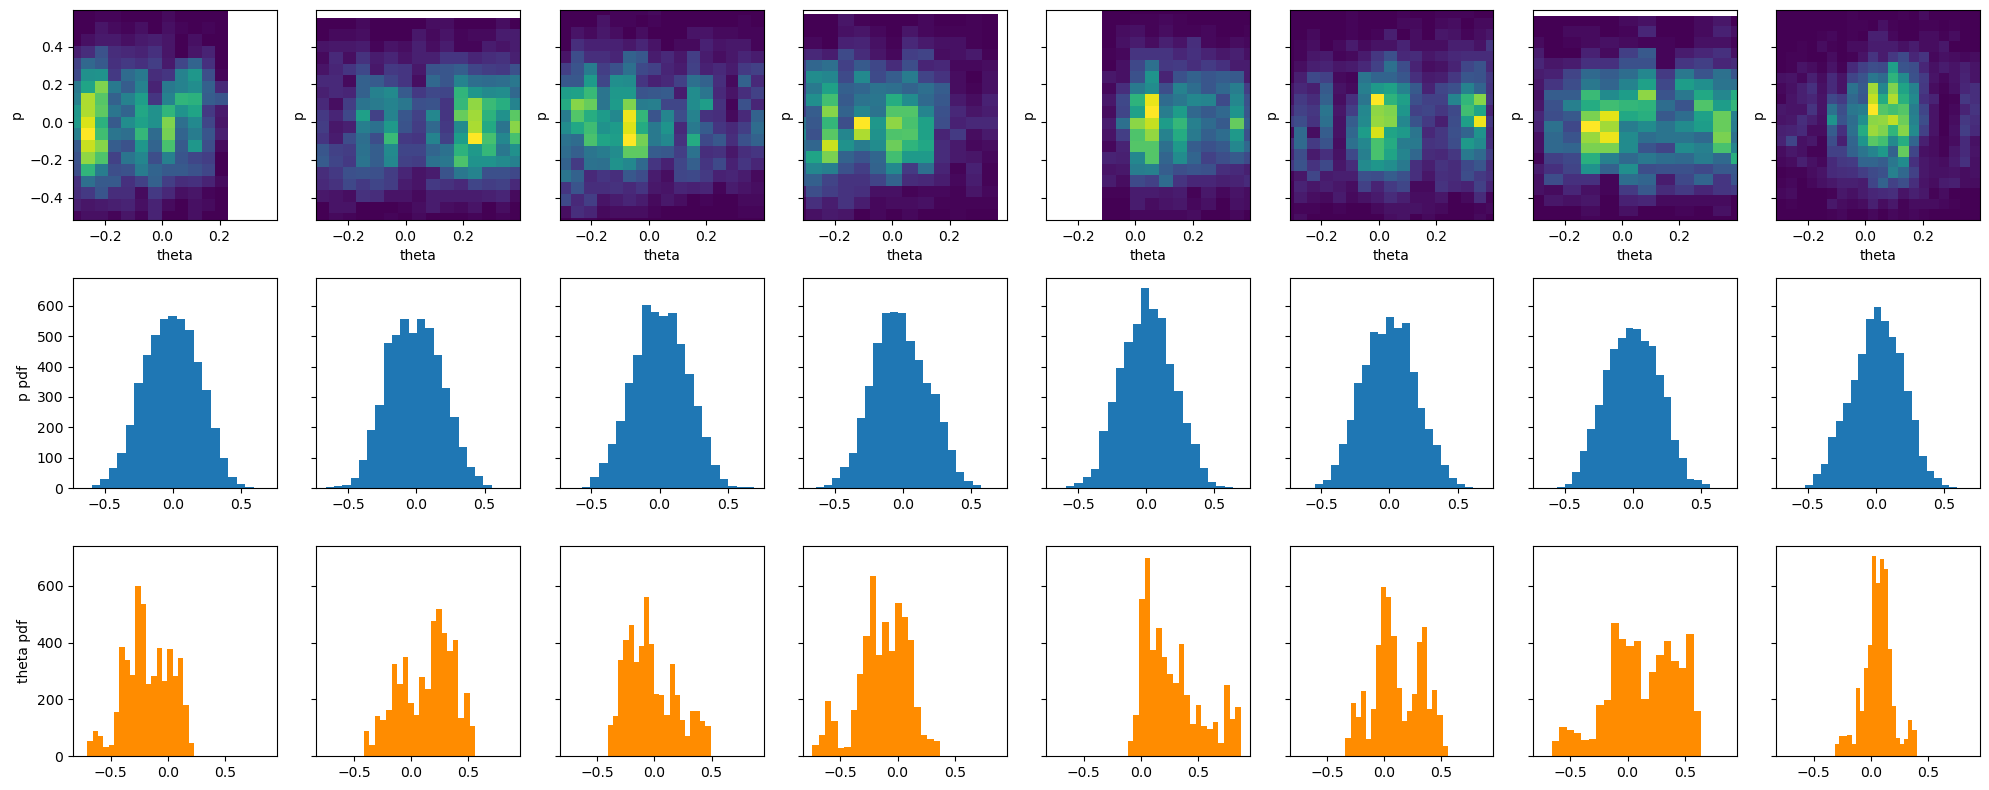

In [18]:
plot_dist(sims)

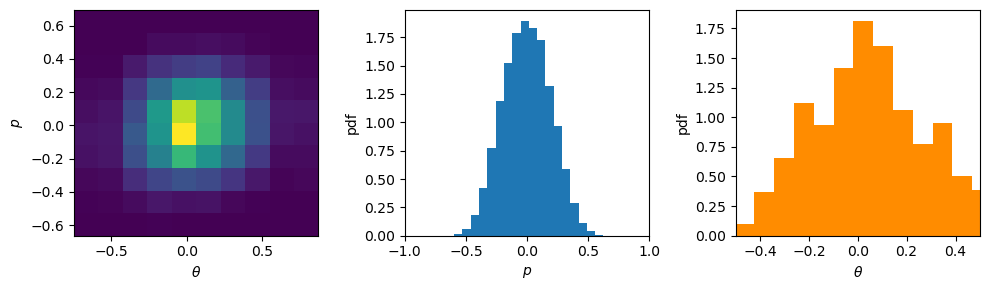

In [19]:
plot_overall_dist(sims)

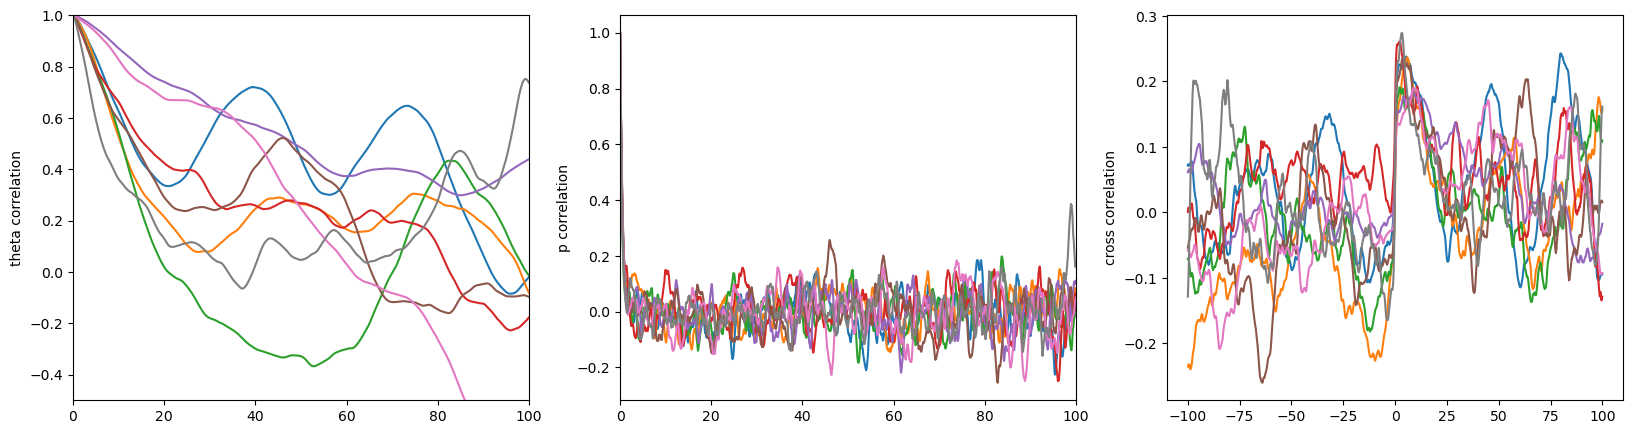

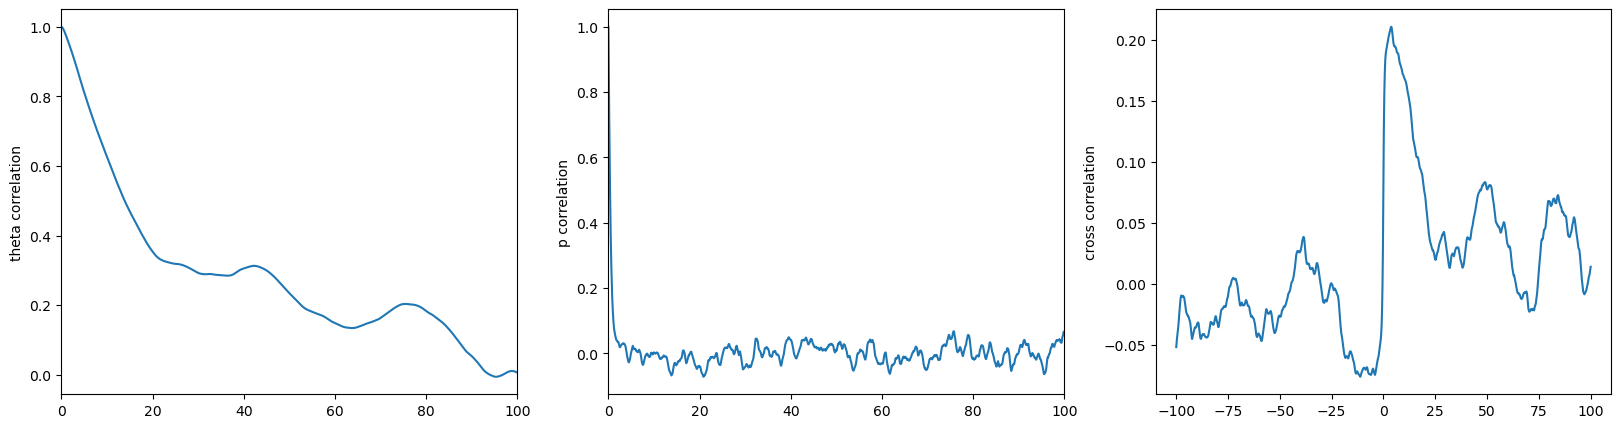

In [20]:
plot_corr(sims, 3000, dt); 

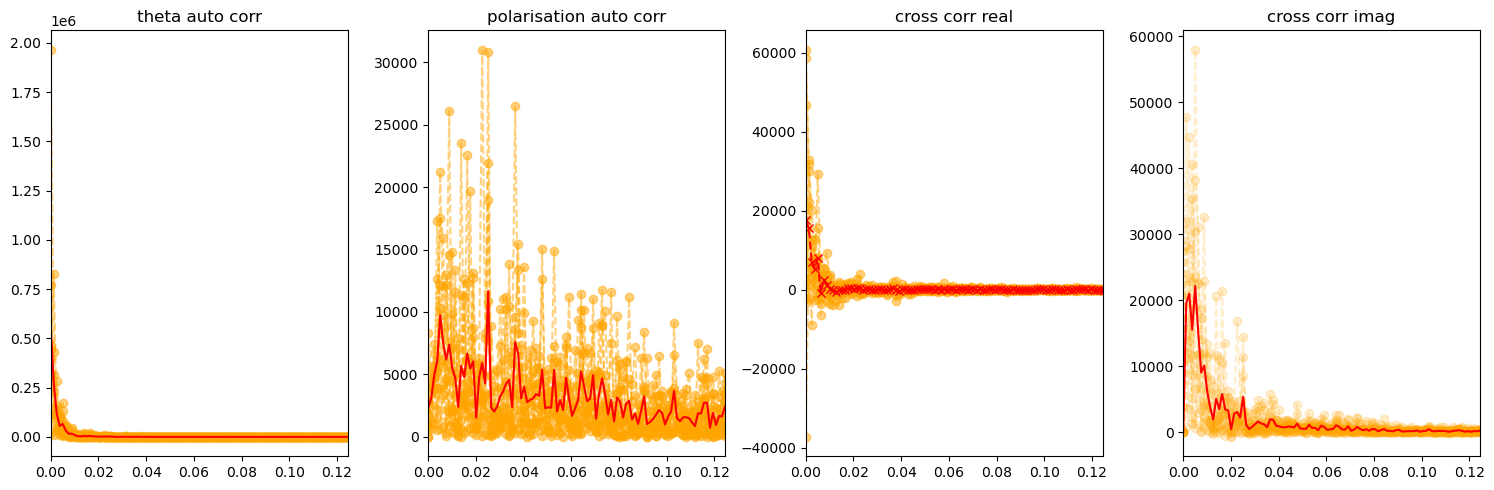

(array([559005.79355, 274163.62484, 118230.4251 , ...,      0.036  ,
             0.03771,      0.02511]),
 array([2354.10031, 3075.85748, 4920.5865 , ...,    2.3705 ,    7.97033,
           6.51692]),
 array([17572.23081    +0.j     , 15711.41228+19559.82294j,
         7100.41118+20987.73865j, ...,     0.02943    -0.06608j,
            0.27059    -0.06773j,     0.11327    +0.j     ]))

In [21]:
plot_corr_ft(np.array(sims), dt)